In [27]:
# import streamlit as st
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import matplotlib.dates as mdate
from matplotlib import rcParams
# import io
# import zipfile
# from pathlib import Path
from site_function import Kuntouling_mingyang,kuitonggou_jinfeng,kangzhuang_yunda
from utils import save_data,save_figures
import matplotlib as mpl
from funtions.gen_docx import gen_document

In [2]:

mpl.font_manager.fontManager.addfont('字体/SIMSUN.ttf')
config = {
    "font.family":'serif',
    # "font.size": 20,
    "mathtext.fontset":'stix',
    "font.serif": ['SIMSUN'],
}
rcParams.update(config)
plt.rcParams['axes.unicode_minus'] = False



In [6]:
phase_name = '昆头岭明阳'
raw_data_path='D:/1 新天/数字运营部 任务/昆头岭手动分析/24年2月/raw_data.csv'
pw_cur_path = 'pw_theory_cur\昆头岭明阳理论功率曲线.xlsx'

In [165]:
import numpy as np
import pandas as pd
# import matplotlib.pyplot as figure

import sys
# sys.path.append('D:/OneDrive - CUHK-Shenzhen/utils/')
# from functions.full_power_time import gen_full_time
# from functions.Temp_warning import plot_scene,plotly_scene,plot_comparison_divide
# import plotly.express as px
import os
import matplotlib.dates as mdate
import sys
# sys.path.append('D:/OneDrive - CUHK-Shenzhen/utils/')
from functions.power_limited import limit_power_detect_loc,limit_power_detect_loc_Goldwind
from functions.plotly_functions import plot_limit_power,plot_yaw_angle,plot_blade_power_all
from matplotlib import rcParams
from functions.Speed_Torque import rated_speed_torque
# from functions.useful_tools import figs2zip
from functions.yaw import yaw_result_generate
from functions.angle_wind import plot_angle_power
from functions.Temp_warning import plot_scene,plot_comparison_divide
from functions.full_power_time import gen_full_time
from matplotlib.pyplot import MultipleLocator
def plot_single_scene(wtg_df,
                      point_name,
                      ylabel,
                      xlabel,
                      style='default',
                      titlesize=28,
                      labelsize=15,
                      edgecolor='white',
                      point_size=50,
                      point_alpha=1,
                      grid=False,
                      wtg_pn='风机',
                      wtg_id = '#01',
                      time_pn='data_time',
                      path=None,
                      title=None,
                      sharpness=200,
                      hlines=[None,None,None,None],
                      annotation_name=['异常值','告警值','故障值','温升异常值'],
                      notation=True,
                      save_fig=True,
                      day_sep=5):
    '''
    画出传入风机数据的指定测点的散点图，不同风机用不同颜色标识。
    Parameters
    ----------
    - wtg_df: 原始数据，规定为筛选某台风机后的数据
    - point_name: 需要画图的测点名称如 齿轮箱后轴承温度
    - ylabel: y轴标签名
    - xlabel: x轴标签名
    - style: 图片风格，如 default,seaborn,ggplot
    - titlesize: 标题大小
    - labelsize: x，y轴标签大小
    - edgecolor: 散点边缘颜色
    - point_size: 散点大小 如50
    - all_color: 如果非空则所有风机都用该颜色画图
    - point_alph：散点透明度 0-1
    - grid: 是否要网格
    - time_pn:时间 point name, `str`
    - wtg_pn: 风机号 point name,`str`
    - path: 保存图片的路径
    - title: 图片标题
    - sharpness： 图片清晰度
    - hlines

    return:
    ----------
    返回图片中所用数据 pd.DataFrame
    返回图片对象：matplotlib fig
    '''
    raw_data = wtg_df[[wtg_pn,time_pn]+[point_name]]
    y = raw_data[point_name]
    x = raw_data[time_pn]
    y_max = wtg_df[point_name].max()
    y_min = wtg_df[point_name].min()
    x_max = max(wtg_df[time_pn])
    x_min = min(wtg_df[time_pn])
    y_axis_min = min(y_min-5,0)
    abnormal = hlines[0]
    if (abnormal is None) | (y_max<abnormal):
        print(f'{point_name}测点无异常数据')
        return None
    else:
        print(f'自动标注,数据最大值为：{round(y_max,2)}，异常阈值：{abnormal}')
    wtg_list = np.unique(wtg_df[wtg_pn])
    if wtg_list != [wtg_id]:
        raise Exception(f'传入了多个风机号{wtg_list}')
    #### 画图
    if style is not None:
        plt.style.use(style)
    if grid:
        plt.grid(True,which='both',ls='dashed')

    fig, ax = plt.subplots(figsize=(15,8))
    ax.scatter(x, y,edgecolors=edgecolor,s=point_size,alpha=point_alpha)
        # ax.plot(x, y, label=column_name)
    # 设置图形y轴的最大值（如果存在故障值，则最大值为故障值）
    if hlines[-2] is not None:
        max_y = max(y_max,hlines[-2])
    else:
        max_y = y_max
    ax.set_ylim(y_axis_min,(max_y+5)) #最大、最小值前后延长5
    y_sep = (y_max-y_axis_min+5)//20
    y_major_locator = MultipleLocator(y_sep) #设置坐标轴间隔
    x_major_locator = mdate.DayLocator(interval=day_sep)
    ax.yaxis.set_major_locator(y_major_locator)
    ax.xaxis.set_major_locator(x_major_locator)
    # 画出告警值和故障值横线（如果有）
    for i,thre in enumerate(hlines[:-1]):
        if thre is not None:
            ax.hlines(y=thre,xmax=x_max,xmin=x_min,color='#B22222',linestyles='dotted',alpha=0.8)
            ax.text(x=x_min,y=thre,s=f'{annotation_name[i]}={thre}℃',color='#B22222',ha = 'left',va='bottom')

    if notation: #是否自动标注图片情况
        abnormal_data = wtg_df[wtg_df[point_name]>abnormal].reset_index()
        abnormal_data['row_num'] = np.arange(abnormal_data.shape[0])
        abnormal_data['index_dif'] = abnormal_data['index']-abnormal_data['row_num']
        ax.scatter(abnormal_data[time_pn],abnormal_data[point_name],color='red',edgecolors=edgecolor,s=point_size,alpha=point_alpha)
        groupby = abnormal_data.groupby('index_dif')
        alarm_result = groupby.count()[['index']]
        alarm_result[wtg_pn] = wtg_id
        alarm_result['start_time'] = groupby.min()[time_pn]
        alarm_result['end_time'] = groupby.max()[time_pn]
        alarm_result['max_value'] = groupby.max()[point_name]
        alarm_result = alarm_result.reset_index(drop=True)
        text_list = []
        for i,info in alarm_result.iterrows():
            # if i%2==0:
            max_n = round(info['max_value'],2)
            stime = info['start_time']
            last_time = info['index']
            text_list.append(f'\n第{i+1}次异常最高达到{max_n}℃,发生于{stime}，持续了{last_time*10}分钟')
            # else:
            #     max_n = round(info['max_value'],2)
            #     stime = info['start_time']
            #     last_time = info['index']
            #     text_list.append(f'第{i+1}次异常最高达到{max_n}℃,发生于{stime}，持续了{last_time*10}分钟')
            ax.vlines(x=stime,ymax=(max_y+5),ymin=y_axis_min,color='#B22222',linestyles='dotted',alpha=0.8)
            text_verbose = ','.join(text_list)
        text = f'{wtg_id}风机{point_name}超过{abnormal}℃。'
        text = text +  text_verbose
        # 创建文本框，将文本置于文本框内
        bbox = { "alpha": 0.5,'facecolor':'white','pad':0.5,'edgecolor':'#DCDCDC','boxstyle':'round'}
        # 所有文本使用统一的样式
        # style = {"size": 15, "color": "#CD2626", "bbox": bbox,'fontweight':'bold'}
        style = {"size": 15, "color": '#B22222', "bbox": bbox,'fontweight':'bold'}
        ax.text(x=x_min,y=y_axis_min+y_sep,s=text,ha = 'left',va='bottom',**style)
        # 设置横轴和纵轴标签
        ax.set_xlabel(xlabel,fontdict = {'fontsize':labelsize,'fontweight':'bold'})
        ax.set_ylabel(ylabel,fontdict = {'fontsize':labelsize,'fontweight':'bold'})
        if title:
            ax.set_title(title,fontdict={'fontsize':titlesize,'fontweight':'bold'})

        if save_fig:
            plt.savefig(path,bbox_inches='tight',facecolor='white',dpi=sharpness)
        plt.close()
        # plot_data = pd.DataFrame(all_y).T
        return fig






class Kuntouling_mingyang():
    def __init__(self,raw_data,theory_pw_cur,
    phase_name = '昆头岭明阳',
    wtg_pn = '风机',
    time_pn ='时间',
    type_pn = '风机类型',
    P_pn = '平均电网有功功率',
    w_pn = '平均风速',
    angle_pn='平均桨叶角度1a',
    cabin_north_angle = '平均机舱对北角度',
    wind_north_angle = '平均风向对北角度',
    generator_speed_pn = '平均发电机转速1',
    cabin_temp_pn = '平均机舱温度',
    Large_components_temp = ['平均齿轮箱前轴承温度','平均齿轮箱后轴承温度','平均发电机前轴承温度','平均发电机后轴承温度',
                      '平均齿轮箱主轴承温度','平均齿轮箱油温',],
    generator_temp = ['平均发电机绕组温度1','平均发电机绕组温度2','平均发电机绕组温度3','平均发电机绕组温度4','平均发电机绕组温度5','平均发电机绕组温度6'],
    pitch_motor_temp =  ['平均桨叶电机1温度','平均桨叶电机2温度','平均桨叶电机3温度']) -> None:
        self.wtg_pn = wtg_pn
        self.time_pn = time_pn
        self.type_pn = type_pn
        self.P_pn = P_pn
        self.w_pn = w_pn
        self.angle_pn = angle_pn
        self.cabin_north_angle = cabin_north_angle
        self.wind_north_angle = wind_north_angle
        self.cabin_temp_pn = cabin_temp_pn
        self.Large_components_temp_ls = Large_components_temp
        self.generator_temp_ls = generator_temp
        self.pitch_motor_temp_ls = pitch_motor_temp

        self.generator_speed_pn = generator_speed_pn
        self.generator_speed_square = '平均发电机转速平方'
        self.generator_speed_square_standard = '发电机转速平方(去量纲)'
        self.generator_torque_pn = '平均发电机转矩'
        self.inter_angle = '机舱与风向夹角'
        self.inter_angle_bin = '机舱与风向夹角_bin'
        self.full_time_pn = 'full_time'


        ## 整理原始数据
        self.raw_data = raw_data[[self.wtg_pn,
                                  self.time_pn,
                                  self.type_pn,
                                  self.P_pn,
                                  self.w_pn,
                                  self.angle_pn,
                                  self.cabin_north_angle,
                                  self.wind_north_angle,
                                  self.generator_speed_pn,
                                  self.cabin_temp_pn,
                                    ]+self.Large_components_temp_ls+
                                    self.generator_temp_ls+
                                    self.pitch_motor_temp_ls]
        if 'Unnamed: 235' in  self.raw_data.columns:
            self.raw_data = self.raw_data.drop('Unnamed: 235',axis=1)
        self.raw_data[self.time_pn] = pd.to_datetime(self.raw_data[self.time_pn])
        self.wtg_list =self.raw_data[[self.wtg_pn,self.type_pn]].drop_duplicates().reset_index(drop=True)

        ## 理论功率数据
        self.theory_pw_cur = theory_pw_cur


    def limit_power(self,angle_threshold=3,
                    gap_threshold=0.1,
                    pw_threshold=0,
                    wtg_multi_type=True):
        
        self.gen_data, self.raw_data_1,unlimit_data_size = limit_power_detect_loc(self.raw_data,
                                                     self.theory_pw_cur,
                                                     wtg_pn = self.wtg_pn,
                                                     time_pn = self.time_pn,
                                                     wind_pn = self.w_pn,
                                                     P_pn = self.P_pn,
                                                     blade_angle_pn = self.angle_pn,
                                                     angle_thr = angle_threshold,
                                                     gap_thr = gap_threshold,
                                                     pw_thr = pw_threshold,
                                                     multiple_type = wtg_multi_type)
        
        figure_limit_power = plot_limit_power(self.raw_data_1,
                                              self.gen_data,
                                              self.theory_pw_cur,
                                              x_pn=self.w_pn,
                                              y_pn=self.P_pn)
        size_change = (self.raw_data.shape[0],unlimit_data_size,self.gen_data.shape[0])
        return figure_limit_power,size_change
    
    def full_time(self,
                  pw_diff_threshold=[500,500],
                  type_ls = ['MySE4.0MW','MySE5.0MW'],
                  rated_pw_ls = [4000,5000,]):
        all_wtg = []
        for _,wtg_info in self.wtg_list.iterrows():
            # print(wtg_info)
            wtg,type = wtg_info
            wtg_dataframe = self.raw_data[self.raw_data[self.wtg_pn]==wtg].reset_index(drop=True).sort_values(by=self.time_pn)
            for j in range(len(type_ls)):
                if type_ls[j] == type:
                    df_ft = gen_full_time(wtg_dataframe,
                                          threshold = pw_diff_threshold[j],
                                          full_pw=rated_pw_ls[j],
                                          time_pn = self.time_pn,
                                          Pw_pn = self.P_pn,
                                          full_time_pn=self.full_time_pn)
                    all_wtg.append(df_ft)

        self.all_data = pd.concat(all_wtg,axis=0)


    def get_all_data(self,):
        scene_list = self.Large_components_temp_ls + self.generator_temp_ls
        for scene in scene_list:
            self.all_data[f'{scene}温升({scene}-舱内温度)'.replace('温度温升','温升')] = self.all_data[scene] - self.all_data[self.cabin_temp_pn]
            self.full_pw = self.all_data[self.all_data[self.full_time_pn]>60].sort_values(by=[self.wtg_pn,self.time_pn]).reset_index(drop=True)

    

    def torque_speed_warning(self,
                             ticks_x_n = 10,
                             u_bound = [5e4,1e6],
                             l_bound=[5810,1.2e5],
                             r_speed=[240,1056],
                             r_torque=[22,3.9],
                             thre=[0.5,0.2]):
        
        self.torque_speed_data = self.gen_data[abs(self.gen_data[self.generator_speed_pn])<2000].reset_index(drop=True)
        self.torque_speed_data[self.generator_torque_pn] = self.torque_speed_data[self.P_pn] / self.torque_speed_data[self.generator_speed_pn]
        self.torque_speed_data[self.generator_speed_square] = self.torque_speed_data[self.generator_speed_pn]**2
        self.torque_speed_data[self.generator_speed_square_standard] = self.torque_speed_data[self.generator_speed_square]/1e4

        results = []
        torque_fig_ls = []
        for _,wtg_info in self.wtg_list.iterrows():
            wtg_id,types = wtg_info
            wtg_data = self.torque_speed_data[self.torque_speed_data[self.wtg_pn]==wtg_id].reset_index(drop=True)
            t2 = f'{wtg_id}最小二乘拟合,型号{types}'
            if types=='MySE5.0MW':
                k,figure1 = rated_speed_torque(wtg_data,
                                               self.generator_speed_square_standard,
                                               self.generator_torque_pn,
                                               limit_pn=self.generator_speed_square,
                                               title=t2,
                                               path=None,
                                               x_ticks_n=ticks_x_n,
                                               upper=u_bound[0],
                                               lower=l_bound[0],
                                               rated_speed=r_speed[0],
                                               rated_torque=r_torque[0],
                                               outlier_thre=thre[0],
                                               save_figure=False)
            elif types=='MySE4.0MW':
                k,figure1 = rated_speed_torque(wtg_data,
                                               self.generator_speed_square_standard,
                                               self.generator_torque_pn,
                                               limit_pn=self.generator_speed_square,
                                               title=t2,
                                               path=None,
                                               x_ticks_n=ticks_x_n,
                                               upper=u_bound[1],
                                               lower=l_bound[1],
                                               rated_speed=r_speed[1],
                                               rated_torque=r_torque[1],
                                               outlier_thre=thre[1],
                                               save_figure=False)
            results.append([wtg_id,types,k])
            torque_fig_ls.append(figure1)

        torque_results_df = pd.DataFrame(results)
        torque_results_df.columns=['风机号','风机型号','斜率']
        return torque_results_df,torque_fig_ls

    def yaw_warning(self):
        self.yaw_data = self.gen_data
        self.yaw_data['dif'] = self.gen_data[self.wind_north_angle]-self.gen_data[self.cabin_north_angle]
        self.yaw_data[self.inter_angle] = np.where(self.yaw_data['dif']>180,360-self.yaw_data['dif'],self.yaw_data['dif'])
        self.yaw_data[self.inter_angle] = np.where(self.yaw_data[self.inter_angle]<-180,-360-self.yaw_data[self.inter_angle],self.yaw_data[self.inter_angle])
        self.yaw_data = self.yaw_data[(self.yaw_data[self.inter_angle]>=-15.25)&(self.yaw_data[self.inter_angle]<=15.25)].reset_index(drop=True)
        bs2 = np.arange(-15.5,16,1)
        ls2 = np.arange(-15,16,1)
        self.yaw_data[self.inter_angle_bin] = pd.cut(self.yaw_data[self.inter_angle],bins=bs2,right=False,labels=ls2).astype('float64')
        figure_yaw_angle_hist = plot_yaw_angle(self.yaw_data,self.inter_angle_bin)
        self.yaw_data['P_th'] = self.yaw_data['P_th_bin']/((self.yaw_data['V_bin']/self.yaw_data[self.w_pn])**3)
        yaw_result_df,wtg_result_list = yaw_result_generate(self.wtg_list,
                                                            self.yaw_data,
                                                            self.inter_angle_bin,
                                                            self.angle_pn,
                                                            wtg_pn=self.wtg_pn,
                                                            P_pn=self.P_pn)
        
        return yaw_result_df,figure_yaw_angle_hist,wtg_result_list

    def blade_warning(self,point_s=10,point_c='r'):
        self.blade_data = self.raw_data[(self.raw_data[self.angle_pn]>-7)&(self.raw_data[self.angle_pn]<100)].reset_index(drop=True)
        fig_ls_blade_type = []
        for wtg_type in np.unique(self.wtg_list[self.type_pn]):
            use_data = self.blade_data[self.blade_data[self.type_pn]==wtg_type].reset_index(drop=True)
            figure = plot_blade_power_all(use_data,
                                          blade_pn=self.angle_pn,
                                          Pw_pn=self.P_pn,
                                          title=f'{wtg_type}功率-桨叶角度散点图')
            fig_ls_blade_type.append(figure)

        fig_ls_blade = []
        fig_ls_blade_time = []
        result_list=[]
        for _,wtg_info in self.wtg_list.iterrows():
            wtg_id,wtg_type = wtg_info
            wtg_data = self.blade_data[self.blade_data[self.wtg_pn]==wtg_id].reset_index(drop=True)
            # save_path = ROOT_PATH +f'桨叶角度/{title1}.jpg'
            min_angle = wtg_data[self.angle_pn].min()
            title1 = f'{wtg_id}风机有功功率-桨叶角度散点图，型号{wtg_type},桨叶角最小值{min_angle}'.replace('/','_')
            figure1 = plot_angle_power(dataframe=wtg_data[wtg_data[self.angle_pn]<5].reset_index(drop=True),
                                       wtg=wtg_id,
                                       wtg_point_name=self.wtg_pn,
                                       y_point_name=self.P_pn,
                                       x_point_name=self.angle_pn,
                                       time_point_name=self.time_pn,
                                       point_size=point_s,
                                       style=None,
                                       path=None,
                                       title=title1,
                                       legend_cols=2,
                                       color=point_c,
                                       comparison=False,
                                       save_figure=False)
            title2 = f'{wtg_id}风机桨叶角度-时间散点图，型号{wtg_type},桨叶角最小值{min_angle}'.replace('/','_')
            figure2 = plot_angle_power(dataframe=wtg_data[wtg_data[self.angle_pn]<5].reset_index(drop=True),
                                       wtg=wtg_id,
                                       wtg_point_name=self.wtg_pn,
                                       y_point_name=self.angle_pn,
                                       x_point_name=self.time_pn,
                                       time_point_name=self.time_pn,
                                       point_size=point_s,
                                       style=None,
                                       path=None,
                                       title=title2,
                                       legend_cols=2,
                                       color=point_c,
                                       comparison=False,
                                       save_figure=False)
            fig_ls_blade.append(figure1)
            fig_ls_blade_time.append(figure2)
            result_list.append([wtg_id,wtg_type,min_angle])
        blade_result_df = pd.DataFrame(result_list)
        blade_result_df.columns = ['风机号','风机型号','桨叶角度最小值']
        return blade_result_df,fig_ls_blade,fig_ls_blade_time,fig_ls_blade_type

    def set_error_threshold(self,):
        scene_list = self.Large_components_temp_ls + self.generator_temp_ls
        warning_thre = [None]*12
        error_thre = [80,80,95,95,70,70] + [145]*6
        abnormal_thre = [70,70,85,85,60,60] + [135]*6
        abnormal_thre2 = [65,65,80,80,55,60] + [130]*6
        self.scene_df = pd.DataFrame({'scene_name':scene_list,'abnormal_thre':abnormal_thre,'warning_thre':warning_thre,'error_thre':error_thre,'abnormal_thre_k':abnormal_thre2})

    def gen_Large_components_temp(self,
                                  if_notation=True):
        figure_list = []
        for _,scene_info in self.scene_df.iterrows():
            scene,abnormal,warning,error,abnormal_k = scene_info
            # print(scene)
            title1 = f'满发60分钟后{scene}'
            # title2 = f'满发60分钟后{scene}温升'.replace('温度温升','温升')
            title2 = f'满发60分钟后{scene}温升\n({scene}-舱内温度)'.replace('温度温升','温升')
            # save_path = 'D:\OneDrive - CUHK-Shenzhen/1 新天\数字运营部 任务\昆头岭手动分析/6、7月/'+ scene+'.png'
            fig1 = plot_scene(self.full_pw,
                              scene,
                              'tab20',
                              '温度（℃）',
                              '次数',
                              style=None,
                              edgecolor='face',
                              point_size=20,
                              point_alpha = 1,
                              title=title1,
                              time_pn=self.time_pn,
                              wtg_pn = self.wtg_pn,
                              legend_cols=2,
                              hlines=[abnormal,warning,error,abnormal_k],
                              notation=if_notation,
                              save_fig=False)

            fig2 = plot_scene(self.full_pw,
                              f'{scene}温升({scene}-舱内温度)'.replace('温度温升','温升'),
                              'tab20',
                              '温度（℃）',
                              '次数',
                              style=None,
                              edgecolor='face',
                              point_size=20,
                              point_alpha = 1,
                              title=title2,
                              time_pn=self.time_pn,
                              wtg_pn =  self.wtg_pn,
                              legend_cols=2,
                              hlines=[None,None,None,abnormal_k],
                              notation=if_notation,
                              save_fig=False)
            figure_list.append(fig1)
            figure_list.append(fig2)        
        return figure_list

    def gen_Large_components_temp_single(self,
                                         if_notation=True):
        figure_list = []
        for _,scene_info in self.scene_df.iterrows():
            scene,abnormal,warning,error,abnormal_k = scene_info
            # print(scene)
            for _,wtg_info in self.wtg_list.iterrows():
                wtg_id,_ = wtg_info
                title1 = f'{wtg_id}风机{scene}'
                wtg_data = self.all_data[self.all_data[self.wtg_pn]==wtg_id].reset_index(drop=True)
                fig1 = plot_single_scene(wtg_data,
                                scene,
                                '温度（℃）',
                                '时间',
                                style=None,
                                edgecolor='face',
                                point_size=15,
                                point_alpha = 1,
                                title=title1,
                                time_pn=self.time_pn,
                                wtg_pn = self.wtg_pn,
                                wtg_id = wtg_id,
                                hlines=[abnormal,warning,error,abnormal_k],
                                notation=if_notation,
                                save_fig=False)
                if fig1 is not None:
                    figure_list.append(fig1)      
        return figure_list        

    def gen_generator_Temp(self,
                           if_h=True,):
        scene_comparison = self.generator_temp_ls
        fig_ls = []
        for _,wtg_info in self.wtg_list.iterrows():
            wtg_id,_ = wtg_info
            title =  f'{wtg_id}风机满发后发电机绕组温度预警'
            fig = plot_comparison_divide(dataframe=self.full_pw,
                                         wtg_id=wtg_id,
                                         point_names=scene_comparison,
                                         ylabel='温度(℃)',
                                         xlabel='次数',
                                         wtg_pn = self.wtg_pn,
                                         time_pn=self.time_pn,
                                         title= title,
                                         point_size=15,
                                         edgecolor='face',
                                         divide_thre = 1.2,
                                         diff_thre = 6,
                                         loc='lower left',
                                         if_hlines=if_h,
                                         save_fig=False)
            if fig is not None:
                fig_ls.append(fig)
        return fig_ls


    def gen_pitch_motor_Temp(self,
                           if_h=True,):
        scene_comparison2 = self.pitch_motor_temp_ls
        fig_ls = []
        for i,wtg_info in self.wtg_list.iterrows():
            wtg_id,_ = wtg_info
            title =  f'{wtg_id}变桨电机温度预警'
            fig =  plot_comparison_divide(dataframe = self.all_data,
                                          wtg_id=wtg_id,
                                          point_names=scene_comparison2,
                                          ylabel='温度(℃)',
                                          xlabel='时间',
                                          wtg_pn = self.wtg_pn,
                                          time_pn=self.time_pn,
                                          title=title,
                                          point_size=6,
                                          edgecolor='face',
                                          color_map='nipy_spectral',
                                          divide_thre=1.2,
                                          diff_thre = 6,
                                          sharpness=500,
                                          loc='lower left',
                                          unit='℃',
                                          if_hlines=if_h,
                                          notation=True,
                                          save_fig=False)
            if fig is not None:
                fig_ls.append(fig)
        return fig_ls

In [166]:

site_dictionary = {'昆头岭明阳':Kuntouling_mingyang,'魁通沟金风四期':kuitonggou_jinfeng,'魁通沟金风五六期':kuitonggou_jinfeng,}
site_model = site_dictionary[phase_name]

if phase_name=='昆头岭明阳':
    # wtg_pn = '风机'
    # time_pn ='时间'
    # type_pn = '风机类型'

    # P_pn = '平均电网有功功率'
    # w_pn = '平均风速'
    # angle_pn='平均桨叶角度1a'
    # cabin_north_angle = '平均机舱对北角度'
    # wind_north_angle = '平均风向对北角度'
    # generator_speed_pn = '平均发电机转速1'
    pn_dictionary = {
        'phase_name':phase_name,
        'wtg_pn':'device_name',
        'time_pn':'data_time',
        'type_pn':'风机类型',
        'P_pn':'发电机有功功率',
        'w_pn':'风速',
        'angle_pn':'桨叶角度1B',
        'cabin_north_angle':'机舱对北角度',
        'wind_north_angle':'风向对北角度',
        'generator_speed_pn':'发电机转速',
        'cabin_temp_pn':'舱内温度',
        'Large_components_temp' : ['齿轮箱前轴承温度','齿轮箱后轴承温度','发电机驱动端轴承温度','发电机非驱动端轴承温度',
                     '齿轮箱主轴承温度', '齿轮箱油池温度',],
        'generator_temp' : ['发电机绕组温度1', '发电机绕组温度2', '发电机绕组温度3', '发电机绕组温度4', '发电机绕组温度5', '发电机绕组温度6'],
        'pitch_motor_temp' : ['1号桨电机温度', '2号桨电机温度', '3号桨电机温度']
    } 
    
if phase_name=='魁通沟金风四期':
    # wtg_pn = 'device_id'
    # time_pn ='data_time'
    # type_pn = '风机类型'

    # P_pn = '发电机有功功率'
    # w_pn = '风速'
    # angle_pn='桨叶片角度1'
    # inter_angle_pn = '机舱与风向夹角'
    # generator_speed_pn = '发电机转速瞬时值'
    # blade_dif_pn = 'blade_dif'
    pn_dictionary = {
        'phase_name':phase_name,
        'wtg_pn':'device_id',
        'time_pn':'data_time',
        'type_pn':'风机类型',
        'P_pn':'发电机有功功率',
        'w_pn':'风速',
        'angle_pn':'桨叶片角度1',
        'inter_angle_pn':'机舱与风向夹角',
        'generator_speed_pn':'发电机转速瞬时值',
        'blade_dif_pn':'blade_dif',
        'cabin_temp_pn':'舱内温度',
        'Large_components_temp' : ['发电机驱动端轴承温度', '发电机非驱动端轴承温度',],
        'generator_temp' : ['发电机绕组温度1','发电机绕组温度2', '发电机绕组温度3', '发电机绕组温度4',
        '发电机绕组温度5', '发电机绕组温度6', '发电机绕组温度7', '发电机绕组温度8', '发电机绕组温度9','发电机绕组温度10',
        '发电机绕组温度11', '发电机绕组温度12'],
        'pitch_motor_temp' : ['1号变桨电机温度', '2号变桨电机温度','3号变桨电机温度']
    }
if phase_name == '魁通沟金风五六期':
    pn_dictionary = {
        'phase_name':phase_name,
        'wtg_pn':'device_id',
        'time_pn':'data_time',
        'type_pn':'风机类型',
        'P_pn':'发电机有功功率',
        'w_pn':'风速',
        'angle_pn':'桨叶片角度1',
        'inter_angle_pn':'机舱与风向夹角',
        'generator_speed_pn':'发电机转速瞬时值',
        'blade_dif_pn':'blade_dif',
        'cabin_temp_pn':'舱内温度',
        'Large_components_temp' : ['发电机前轴承外圈温度','发电机后轴承外圈温度', '发电机前轴承内圈温度', '发电机后轴承内圈温度'],
        'generator_temp' : ['发电机绕组温度最大值',],
        'pitch_motor_temp' : ['1号变桨电机温度', '2号变桨电机温度','3号变桨电机温度']
    }
    
def load_data(url):
    df = pd.read_csv(url)
    return df

In [167]:
if raw_data_path is not None:
    raw_data = load_data(raw_data_path)
else:
    raw_data = load_data('D:/1 新天\数字运营部 任务\昆头岭手动分析/24年1月/raw_data.csv')
theory_pw_cur = pd.read_excel(pw_cur_path if pw_cur_path else 'pw_theory_cur\昆头岭明阳理论功率曲线.xlsx')


In [168]:
site_instance = site_model(raw_data,theory_pw_cur,**pn_dictionary)
site_instance.raw_data

<ipython-input-165-61f9d74fcabb>:223: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.raw_data[self.time_pn] = pd.to_datetime(self.raw_data[self.time_pn])


,device_name,data_time,风机类型,发电机有功功率,风速,桨叶角度1B,机舱对北角度,风向对北角度,发电机转速,舱内温度,齿轮箱前轴承温度,齿轮箱后轴承温度,发电机驱动端轴承温度,发电机非驱动端轴承温度,齿轮箱主轴承温度,齿轮箱油池温度,发电机绕组温度1,发电机绕组温度2,发电机绕组温度3,发电机绕组温度4,发电机绕组温度5,发电机绕组温度6,1号桨电机温度,2号桨电机温度,3号桨电机温度
0,#74,2024-02-01 00:10:00,MySE5.0MW,182.6821,3.3794,-0.4500,66.8000,64.4903,92.5571,13.1611,43.2333,43.1833,42.0353,42.5400,32.7500,44.5,27.4940,28.5677,27.8873,28.4826,28.3529,28.7919,2.5000,2.0000,2.5172
1,#74,2024-02-01 00:20:00,MySE5.0MW,227.6313,3.6101,-0.4950,66.8000,63.4600,92.5000,13.3273,43.1200,43.0375,42.0250,42.4357,32.6500,44.0,27.5723,28.6247,27.9263,28.5383,28.4057,28.8273,2.0000,2.0000,2.7619
2,#74,2024-02-01 00:30:00,MySE5.0MW,264.1515,3.7004,-0.5000,66.8000,59.9167,94.7586,13.5400,43.1000,42.9600,41.9692,42.4385,32.6000,44.0,27.7260,28.7927,28.0510,28.7043,28.5820,29.0290,2.0000,2.0000,2.8235
3,#74,2024-02-01 00:40:00,MySE5.0MW,270.6279,3.7064,-0.5000,66.8000,63.3088,94.8286,13.5400,43.0222,42.9625,41.8450,42.3320,32.5200,44.0,27.9267,28.9773,28.2217,28.9012,28.7368,29.1550,2.0000,2.0000,2.7143
4,#74,2024-02-01 00:50:00,MySE5.0MW,351.4725,3.9849,-0.4450,58.7167,54.0676,111.2574,13.5714,43.0500,42.9000,41.7846,42.3545,32.4417,44.0,28.0987,29.1657,28.4387,29.0929,28.9547,29.3703,1.6667,2.0000,2.7500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66288,#89,2024-02-29 23:10:00,MySE4.0MW,1080.2528,5.6284,0.2636,259.9667,260.4600,811.1771,-2.4900,47.4800,49.7667,57.3750,47.4632,32.9000,49.5,54.3303,50.4080,50.0697,50.7330,55.1773,55.2543,16.0000,12.2381,12.0000
66289,#89,2024-02-29 23:20:00,MySE4.0MW,868.2570,5.2843,-0.0867,260.2667,258.9700,757.9172,-3.4214,47.6000,49.8429,57.2143,47.3150,33.0000,49.5,53.7487,49.8513,49.4947,50.1353,54.4713,54.5430,15.0588,12.6000,11.3333
66290,#89,2024-02-29 23:30:00,MySE4.0MW,889.4800,5.2801,0.8000,262.9000,261.4676,763.2952,-3.9500,47.7111,49.8308,56.9250,47.2529,32.9750,50.0,52.8343,49.0437,48.6600,49.2215,53.4268,53.4453,15.5000,12.0000,11.2105
66291,#89,2024-02-29 23:40:00,MySE4.0MW,787.8418,5.0513,0.0133,262.9000,261.7706,733.4826,-4.5923,47.7385,49.7600,56.2231,46.7056,33.0625,49.0,51.1047,47.5063,47.0630,47.8362,51.8574,51.8850,15.3333,11.3750,11.8182


d:\github_repository\xintian\xintian\power_limited.py:213: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['V_bin'] = pd.cut(data[wind_pn],bins=bs,right=False,labels=ls).astype('float64')


原始数据(66293, 25)
非限功率点：(52918, 33)
功率小于0点:(7169, 33)
正常发电点:(45743, 33)
原始数据、剔除限电后、剔除功率小于等于0后的数据大小分别为(66293, 52918, 45743)


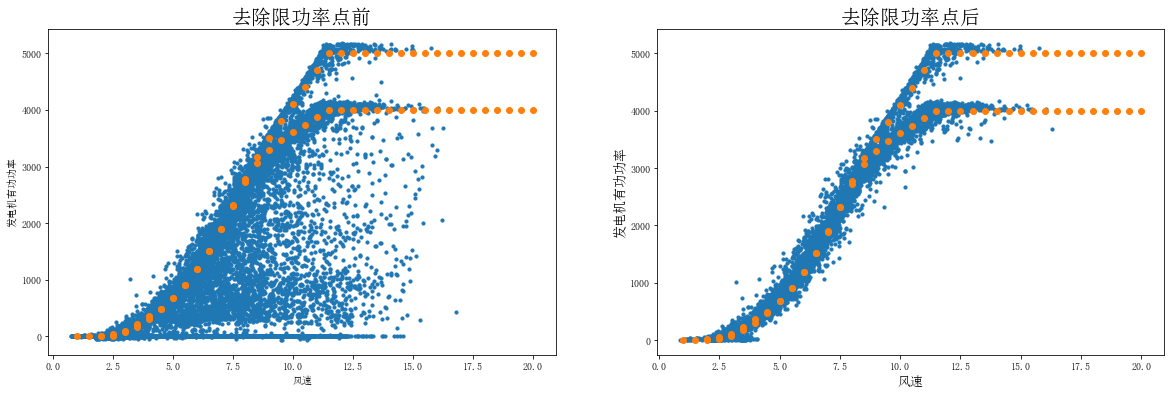

In [169]:
fig_limit_power,size_changing = site_instance.limit_power()
print(f'原始数据、剔除限电后、剔除功率小于等于0后的数据大小分别为{size_changing}')
fig_limit_power

In [170]:
torque_results_df,torque_fig_ls = site_instance.torque_speed_warning()

In [171]:
torque_results_df

,风机号,风机型号,斜率
0,#74,MySE5.0MW,1.911413
1,#75,MySE4.0MW,0.019050
2,#76,MySE4.0MW,0.019734
3,#77,MySE4.0MW,0.019225
4,#78,MySE4.0MW,0.019081
5,#79,MySE4.0MW,0.019327
6,#80,MySE4.0MW,0.019508
7,#81,MySE5.0MW,1.870642
8,#82,MySE4.0MW,0.019204
9,#83,MySE4.0MW,0.019653


In [172]:
yaw_result_df,yaw_angle_hist,yaw_result_list = site_instance.yaw_warning()
yaw_result_df

,风机号,风机型号,计数,K值最大夹角,频率最高夹角,差值,0°K值,最高K值,频率最高K值,最高K值-0°K值
0,#74,MySE5.0MW,2994,-7.0,-2.0,5.0,1.0461,1.0596,1.0437,0.0135
1,#75,MySE4.0MW,2257,7.0,0.0,7.0,1.0253,1.0302,1.0253,0.0049
2,#76,MySE4.0MW,2342,2.0,-1.0,3.0,1.0286,1.0301,1.0290,0.0015
3,#77,MySE4.0MW,2579,1.0,2.0,1.0,1.0239,1.0290,1.0235,0.0051
4,#78,MySE4.0MW,2502,-5.0,1.0,6.0,1.0330,1.0449,1.0173,0.0119
5,#79,MySE4.0MW,2909,4.0,0.0,4.0,1.0360,1.0385,1.0360,0.0025
6,#80,MySE4.0MW,2792,-5.0,-1.0,4.0,1.0292,1.0492,1.0340,0.0200
7,#81,MySE5.0MW,3138,-7.0,1.0,8.0,1.0416,1.0598,1.0379,0.0182
8,#82,MySE4.0MW,2384,1.0,-2.0,3.0,1.0222,1.0315,1.0222,0.0093
9,#83,MySE4.0MW,2514,-3.0,2.0,5.0,1.0329,1.0420,1.0384,0.0091


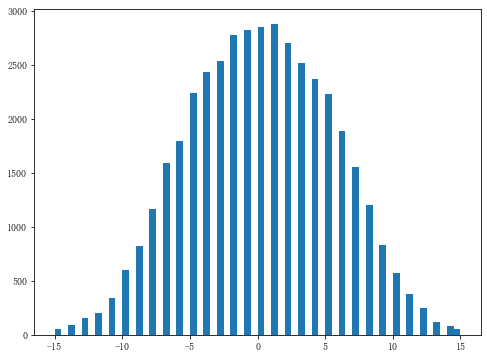

In [173]:
yaw_angle_hist

In [174]:
blade_result_df,fig_ls_blade,fig_ls_blade_time,fig_ls_blade_type = site_instance.blade_warning()
blade_result_df

,风机号,风机型号,桨叶角度最小值
0,#74,MySE5.0MW,-0.5
1,#75,MySE4.0MW,-0.5
2,#76,MySE4.0MW,-0.5
3,#77,MySE4.0MW,-0.5
4,#78,MySE4.0MW,-0.5
5,#79,MySE4.0MW,-0.5
6,#80,MySE4.0MW,-0.5
7,#81,MySE5.0MW,-0.5
8,#82,MySE4.0MW,0.0
9,#83,MySE4.0MW,-0.5


In [175]:
site_instance.full_time()

In [176]:

all_data = site_instance.get_all_data()
site_instance.set_error_threshold()
site_instance.all_data

,device_name,data_time,风机类型,发电机有功功率,风速,桨叶角度1B,机舱对北角度,风向对北角度,发电机转速,舱内温度,齿轮箱前轴承温度,齿轮箱后轴承温度,发电机驱动端轴承温度,发电机非驱动端轴承温度,齿轮箱主轴承温度,齿轮箱油池温度,发电机绕组温度1,发电机绕组温度2,发电机绕组温度3,发电机绕组温度4,发电机绕组温度5,发电机绕组温度6,1号桨电机温度,2号桨电机温度,3号桨电机温度,V_bin,P_bin,full_time,pw_diff,齿轮箱前轴承温升(齿轮箱前轴承温度-舱内温度),齿轮箱后轴承温升(齿轮箱后轴承温度-舱内温度),发电机驱动端轴承温升(发电机驱动端轴承温度-舱内温度),发电机非驱动端轴承温升(发电机非驱动端轴承温度-舱内温度),齿轮箱主轴承温升(齿轮箱主轴承温度-舱内温度),齿轮箱油池温升(齿轮箱油池温度-舱内温度),发电机绕组温度1温升(发电机绕组温度1-舱内温度),发电机绕组温度2温升(发电机绕组温度2-舱内温度),发电机绕组温度3温升(发电机绕组温度3-舱内温度),发电机绕组温度4温升(发电机绕组温度4-舱内温度),发电机绕组温度5温升(发电机绕组温度5-舱内温度),发电机绕组温度6温升(发电机绕组温度6-舱内温度)
0,#74,2024-02-01 00:10:00,MySE5.0MW,182.6821,3.3794,-0.4500,66.8000,64.4903,92.5571,13.1611,43.2333,43.1833,42.0353,42.5400,32.7500,44.5,27.4940,28.5677,27.8873,28.4826,28.3529,28.7919,2.5000,2.0000,2.5172,3.5,202.946389,0,4817.3179,30.0722,30.0222,28.8742,29.3789,19.5889,31.3389,14.3329,15.4066,14.7262,15.3215,15.1918,15.6308
1,#74,2024-02-01 00:20:00,MySE5.0MW,227.6313,3.6101,-0.4950,66.8000,63.4600,92.5000,13.3273,43.1200,43.0375,42.0250,42.4357,32.6500,44.0,27.5723,28.6247,27.9263,28.5383,28.4057,28.8273,2.0000,2.0000,2.7619,3.5,207.433271,0,4772.3687,29.7927,29.7102,28.6977,29.1084,19.3227,30.6727,14.2450,15.2974,14.5990,15.2110,15.0784,15.5000
2,#74,2024-02-01 00:30:00,MySE5.0MW,264.1515,3.7004,-0.5000,66.8000,59.9167,94.7586,13.5400,43.1000,42.9600,41.9692,42.4385,32.6000,44.0,27.7260,28.7927,28.0510,28.7043,28.5820,29.0290,2.0000,2.0000,2.8235,3.5,223.517328,0,4735.8485,29.5600,29.4200,28.4292,28.8985,19.0600,30.4600,14.1860,15.2527,14.5110,15.1643,15.0420,15.4890
3,#74,2024-02-01 00:40:00,MySE5.0MW,270.6279,3.7064,-0.5000,66.8000,63.3088,94.8286,13.5400,43.0222,42.9625,41.8450,42.3320,32.5200,44.0,27.9267,28.9773,28.2217,28.9012,28.7368,29.1550,2.0000,2.0000,2.7143,3.5,227.887151,0,4729.3721,29.4822,29.4225,28.3050,28.7920,18.9800,30.4600,14.3867,15.4373,14.6817,15.3612,15.1968,15.6150
4,#74,2024-02-01 00:50:00,MySE5.0MW,351.4725,3.9849,-0.4450,58.7167,54.0676,111.2574,13.5714,43.0500,42.9000,41.7846,42.3545,32.4417,44.0,28.0987,29.1657,28.4387,29.0929,28.9547,29.3703,1.6667,2.0000,2.7500,4.0,355.483168,0,4648.5275,29.4786,29.3286,28.2132,28.7831,18.8703,30.4286,14.5273,15.5943,14.8673,15.5215,15.3833,15.7989
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4139,#89,2024-02-29 23:10:00,MySE4.0MW,1080.2528,5.6284,0.2636,259.9667,260.4600,811.1771,-2.4900,47.4800,49.7667,57.3750,47.4632,32.9000,49.5,54.3303,50.4080,50.0697,50.7330,55.1773,55.2543,16.0000,12.2381,12.0000,5.5,1007.995530,0,2919.7472,49.9700,52.2567,59.8650,49.9532,35.3900,51.9900,56.8203,52.8980,52.5597,53.2230,57.6673,57.7443
4140,#89,2024-02-29 23:20:00,MySE4.0MW,868.2570,5.2843,-0.0867,260.2667,258.9700,757.9172,-3.4214,47.6000,49.8429,57.2143,47.3150,33.0000,49.5,53.7487,49.8513,49.4947,50.1353,54.4713,54.5430,15.0588,12.6000,11.3333,5.5,978.980329,0,3131.7430,51.0214,53.2643,60.6357,50.7364,36.4214,52.9214,57.1701,53.2727,52.9161,53.5567,57.8927,57.9644
4141,#89,2024-02-29 23:30:00,MySE4.0MW,889.4800,5.2801,0.8000,262.9000,261.4676,763.2952,-3.9500,47.7111,49.8308,56.9250,47.2529,32.9750,50.0,52.8343,49.0437,48.6600,49.2215,53.4268,53.4453,15.5000,12.0000,11.2105,5.5,1005.304931,0,3110.5200,51.6611,53.7808,60.8750,51.2029,36.9250,53.9500,56.7843,52.9937,52.6100,53.1715,57.3768,57.3953
4142,#89,2024-02-29 23:40:00,MySE4.0MW,787.8418,5.0513,0.0133,262.9000,261.7706,733.4826,-4.5923,47.7385,49.7600,56.2231,46.7056,33.0625,49.0,51.1047,47.5063,47.0630,47.8362,51.8574,51.8850,15.3333,11.3750,11.8182,5.0,764.081255,0,3212.1582,52.3308,54.3523,60.8154,51.2979,37.6548,53.5923,55.6970,52.0986,51.6553,52.4285,56.4497,56.4773


In [177]:
site_instance.scene_df

,scene_name,abnormal_thre,warning_thre,error_thre,abnormal_thre_k
0,齿轮箱前轴承温度,70,None,80,65
1,齿轮箱后轴承温度,70,None,80,65
2,发电机驱动端轴承温度,85,None,95,80
3,发电机非驱动端轴承温度,85,None,95,80
4,齿轮箱主轴承温度,60,None,70,55
5,齿轮箱油池温度,60,None,70,60
6,发电机绕组温度1,135,None,145,130
7,发电机绕组温度2,135,None,145,130
8,发电机绕组温度3,135,None,145,130
9,发电机绕组温度4,135,None,145,130


In [178]:
if_n=True
Large_components_fig = site_instance.gen_Large_components_temp(if_notation=if_n)

自动标注,数据最大值为：60.2，异常阈值：70
自动标注,数据最大值为：65.96，异常阈值：65
有异常数据
自动标注,数据最大值为：62.02，异常阈值：70
自动标注,数据最大值为：67.75，异常阈值：65
有异常数据
自动标注,数据最大值为：77.84，异常阈值：85
自动标注,数据最大值为：75.57，异常阈值：80
自动标注,数据最大值为：79.25，异常阈值：85
自动标注,数据最大值为：71.36，异常阈值：80
自动标注,数据最大值为：44.83，异常阈值：60
自动标注,数据最大值为：46.99，异常阈值：55
自动标注,数据最大值为：62.0，异常阈值：60
有异常数据
自动标注,数据最大值为：67.76，异常阈值：60
有异常数据
自动标注,数据最大值为：129.31，异常阈值：135
自动标注,数据最大值为：117.46，异常阈值：130
自动标注,数据最大值为：129.41，异常阈值：135
自动标注,数据最大值为：118.7，异常阈值：130
自动标注,数据最大值为：130.17，异常阈值：135
自动标注,数据最大值为：119.13，异常阈值：130
自动标注,数据最大值为：129.28，异常阈值：135
自动标注,数据最大值为：118.24，异常阈值：130
自动标注,数据最大值为：129.73，异常阈值：135
自动标注,数据最大值为：118.69，异常阈值：130
自动标注,数据最大值为：133.01，异常阈值：135
自动标注,数据最大值为：121.54，异常阈值：130


In [179]:
Large_components_fig_single = site_instance.gen_Large_components_temp_single()

齿轮箱前轴承温度测点无异常数据
齿轮箱前轴承温度测点无异常数据
齿轮箱前轴承温度测点无异常数据
齿轮箱前轴承温度测点无异常数据
齿轮箱前轴承温度测点无异常数据
齿轮箱前轴承温度测点无异常数据
齿轮箱前轴承温度测点无异常数据
齿轮箱前轴承温度测点无异常数据
齿轮箱前轴承温度测点无异常数据
齿轮箱前轴承温度测点无异常数据
齿轮箱前轴承温度测点无异常数据
齿轮箱前轴承温度测点无异常数据
齿轮箱前轴承温度测点无异常数据
齿轮箱前轴承温度测点无异常数据
齿轮箱前轴承温度测点无异常数据
齿轮箱前轴承温度测点无异常数据
齿轮箱后轴承温度测点无异常数据
齿轮箱后轴承温度测点无异常数据
齿轮箱后轴承温度测点无异常数据
齿轮箱后轴承温度测点无异常数据
自动标注,数据最大值为：70.1，异常阈值：70
齿轮箱后轴承温度测点无异常数据
齿轮箱后轴承温度测点无异常数据
齿轮箱后轴承温度测点无异常数据
齿轮箱后轴承温度测点无异常数据
齿轮箱后轴承温度测点无异常数据
齿轮箱后轴承温度测点无异常数据
齿轮箱后轴承温度测点无异常数据
齿轮箱后轴承温度测点无异常数据
齿轮箱后轴承温度测点无异常数据
齿轮箱后轴承温度测点无异常数据
齿轮箱后轴承温度测点无异常数据
发电机驱动端轴承温度测点无异常数据
发电机驱动端轴承温度测点无异常数据
发电机驱动端轴承温度测点无异常数据
发电机驱动端轴承温度测点无异常数据
发电机驱动端轴承温度测点无异常数据
发电机驱动端轴承温度测点无异常数据
发电机驱动端轴承温度测点无异常数据
发电机驱动端轴承温度测点无异常数据
发电机驱动端轴承温度测点无异常数据
发电机驱动端轴承温度测点无异常数据
发电机驱动端轴承温度测点无异常数据
发电机驱动端轴承温度测点无异常数据
发电机驱动端轴承温度测点无异常数据
发电机驱动端轴承温度测点无异常数据
发电机驱动端轴承温度测点无异常数据
发电机驱动端轴承温度测点无异常数据
发电机非驱动端轴承温度测点无异常数据
发电机非驱动端轴承温度测点无异常数据
发电机非驱动端轴承温度测点无异常数据
发电机非驱动端轴承温度测点无异常数据
发电机非驱动端轴承温度测点无异常数据
自动标注,数据最大值为：85.55，异常阈值：85
发电机非驱动端轴承温度测点无异常数据
发电机非驱动端轴承温度测点无异常数据
发电机非驱动端轴承温度测点无异常数据
发电机非驱动端轴承温度测点

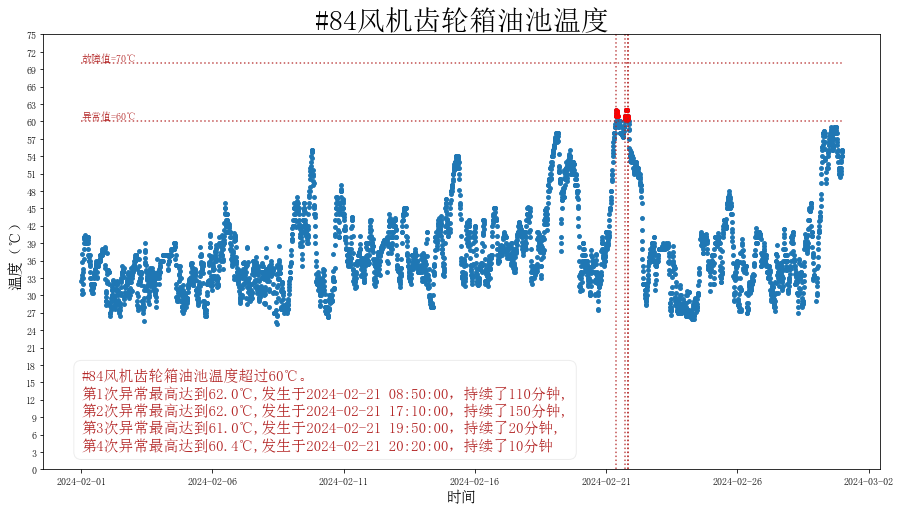

In [185]:
Large_components_fig_single[3]

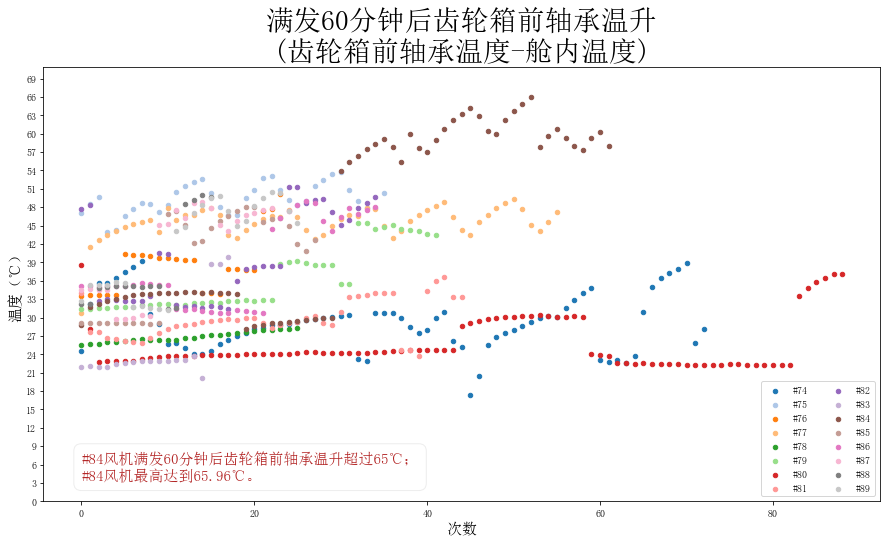

In [181]:
Large_components_fig[1]

In [21]:
site_instance.full_pw

,device_name,data_time,风机类型,发电机有功功率,风速,桨叶角度1B,机舱对北角度,风向对北角度,发电机转速,舱内温度,齿轮箱前轴承温度,齿轮箱后轴承温度,发电机驱动端轴承温度,发电机非驱动端轴承温度,齿轮箱主轴承温度,齿轮箱油池温度,发电机绕组温度1,发电机绕组温度2,发电机绕组温度3,发电机绕组温度4,发电机绕组温度5,发电机绕组温度6,1号桨电机温度,2号桨电机温度,3号桨电机温度,V_bin,P_bin,full_time,pw_diff,齿轮箱前轴承温升(齿轮箱前轴承温度-舱内温度),齿轮箱后轴承温升(齿轮箱后轴承温度-舱内温度),发电机驱动端轴承温升(发电机驱动端轴承温度-舱内温度),发电机非驱动端轴承温升(发电机非驱动端轴承温度-舱内温度),齿轮箱主轴承温升(齿轮箱主轴承温度-舱内温度),齿轮箱油池温升(齿轮箱油池温度-舱内温度),发电机绕组温度1温升(发电机绕组温度1-舱内温度),发电机绕组温度2温升(发电机绕组温度2-舱内温度),发电机绕组温度3温升(发电机绕组温度3-舱内温度),发电机绕组温度4温升(发电机绕组温度4-舱内温度),发电机绕组温度5温升(发电机绕组温度5-舱内温度),发电机绕组温度6温升(发电机绕组温度6-舱内温度)
0,#74,2024-02-09 18:30:00,MySE5.0MW,5152.8882,13.6900,7.8930,33.700,43.9767,240.6124,25.7167,50.2667,51.9667,63.0190,61.2600,40.8000,55.0000,95.9947,97.6827,96.2507,97.6053,98.3923,99.6847,14.3500,15.5789,16.5000,13.5,4941.305223,70,-152.8882,24.5500,26.2500,37.3023,35.5433,15.0833,29.2833,70.2780,71.9660,70.5340,71.8886,72.6756,73.9680
1,#74,2024-02-09 18:40:00,MySE5.0MW,5113.9605,12.2302,5.9713,37.875,44.0367,239.8209,18.2565,50.4333,52.1750,61.0962,61.1286,40.8500,55.0000,96.4263,98.1293,96.6350,98.0317,98.8553,100.0527,14.8000,15.5455,16.4500,12.0,4830.592804,80,-113.9605,32.1768,33.9185,42.8397,42.8721,22.5935,36.7435,78.1698,79.8728,78.3785,79.7752,80.5988,81.7962
2,#74,2024-02-09 18:50:00,MySE5.0MW,4955.8939,11.1651,3.0430,41.200,46.0167,240.2263,13.9176,49.5941,51.5750,59.9760,60.5867,40.9000,54.0000,94.6163,96.7037,94.7433,96.3473,97.1387,98.0283,15.4615,16.4000,17.6250,11.0,4739.278212,90,44.1061,35.6765,37.6574,46.0584,46.6691,26.9824,40.0824,80.6987,82.7861,80.8257,82.4297,83.2211,84.1107
3,#74,2024-02-09 19:00:00,MySE5.0MW,4774.3034,10.8521,2.5063,41.700,47.6767,240.0977,12.6971,48.3167,50.5818,59.1400,59.7250,40.8333,53.0000,91.4417,93.8650,91.6340,93.3410,93.9763,94.6730,16.3846,17.4615,18.7778,11.0,4972.178470,100,225.6966,35.6196,37.8847,46.4429,47.0279,28.1362,40.3029,78.7446,81.1679,78.9369,80.6439,81.2792,81.9759
4,#74,2024-02-09 19:10:00,MySE5.0MW,5095.9429,11.3697,3.8700,43.300,46.0267,240.4580,11.8069,48.3000,50.4000,58.9474,59.0846,40.6333,53.0000,89.7547,92.3507,89.9930,91.8693,92.2067,93.0617,16.2222,18.0000,19.5000,11.5,5273.161316,110,-95.9429,36.4931,38.5931,47.1405,47.2777,28.8264,41.1931,77.9478,80.5438,78.1861,80.0624,80.3998,81.2548
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
629,#89,2024-02-21 18:20:00,MySE4.0MW,3817.8065,10.4243,3.7350,320.900,322.7844,1052.2160,-3.4857,46.0100,49.3636,62.0429,51.3313,31.4667,49.6667,102.9857,100.3423,96.8887,99.6675,103.9475,103.9238,24.9167,22.6667,21.5000,10.5,3901.585298,170,182.1935,49.4957,52.8493,65.5286,54.8170,34.9524,53.1524,106.4714,103.8280,100.3744,103.1532,107.4332,107.4095
630,#89,2024-02-21 18:30:00,MySE4.0MW,3966.8289,10.8063,4.2550,320.900,324.6733,1052.9760,-4.4917,46.0444,49.4091,61.9333,51.3000,31.4667,49.3750,101.9203,99.3117,95.8853,99.0367,103.0813,103.0023,25.6667,23.2857,21.3333,11.0,4183.988323,180,33.1711,50.5361,53.9008,66.4250,55.7917,35.9584,53.8667,106.4120,103.8034,100.3770,103.5284,107.5730,107.4940
631,#89,2024-02-21 18:40:00,MySE4.0MW,4120.8297,11.2013,6.6031,323.450,327.5290,1055.0114,-4.1710,46.1364,49.5286,61.9600,51.2136,31.5667,49.5000,101.9603,99.2963,95.7367,98.9744,102.9616,102.9916,24.6667,22.6190,21.5000,11.0,3902.630512,190,-120.8297,50.3074,53.6996,66.1310,55.3846,35.7377,53.6710,106.1313,103.4673,99.9077,103.1454,107.1326,107.1626
632,#89,2024-02-21 18:50:00,MySE4.0MW,4092.1818,11.1437,4.7409,325.500,330.3656,1052.9053,-1.4100,46.0556,49.4143,61.9400,51.1913,31.4000,49.5714,103.0083,100.4017,96.9683,100.0897,104.1009,104.0069,24.8889,22.8000,21.2000,11.0,3935.906195,200,-92.1818,47.4656,50.8243,63.3500,52.6013,32.8100,50.9814,104.4183,101.8117,98.3783,101.4997,105.5109,105.4169


In [22]:
site_instance.generator_temp_ls

['发电机绕组温度1', '发电机绕组温度2', '发电机绕组温度3', '发电机绕组温度4', '发电机绕组温度5', '发电机绕组温度6']

In [23]:
generator_temp_fig = site_instance.gen_generator_Temp()
pitch_motor_temp_fig = site_instance.gen_pitch_motor_Temp()

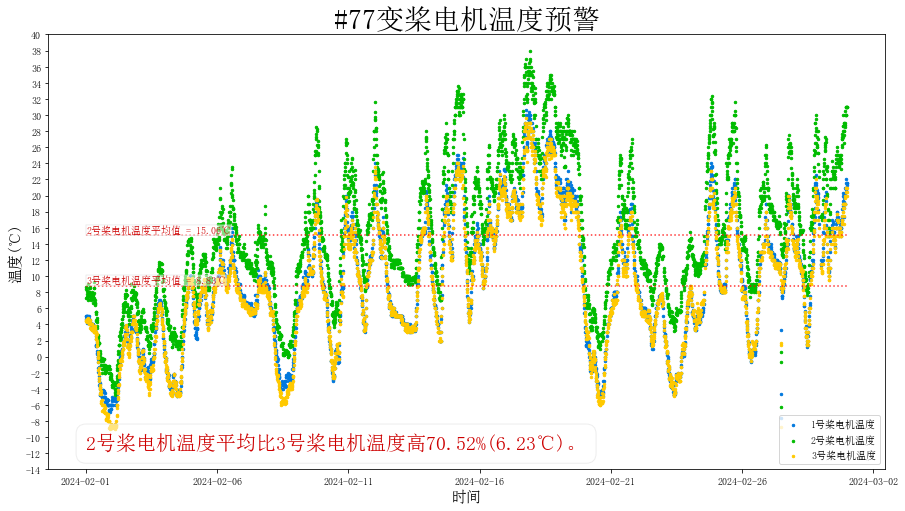

In [26]:
pitch_motor_temp_fig[0]

In [189]:
import pandas as pd
from docx import Document 
from docx.shared import Cm
import math
import io
from docx.oxml.ns import qn

class gen_document():
    def __init__(self,
                 instance,
                #  Large_components_temp_ls,
                #  generator_temp_ls,
                #  pitch_motor_temp_ls,
                 Large_component_fig_ls,
                 Large_components_fig_single_ls,
                 generator_temp_fig_ls,
                 pitch_motor_temp_fig_ls,
                 torque_fig_ls,
                 yaw_data,
                 blade_pw_fig_ls,
                 blade_time_fig_ls,
                 ):
        self.Large_components_temp_ls = instance.Large_components_temp_ls
        self.Large_components_temp_ls = instance.Large_components_temp_ls
        self.generator_temp_ls = instance.generator_temp_ls
        self.pitch_motor_temp_ls = instance.pitch_motor_temp_ls
        self.Large_component_fig_ls = Large_component_fig_ls
        self.Large_components_fig_single_ls = Large_components_fig_single_ls
        self.generator_temp_fig_ls = generator_temp_fig_ls
        self.pitch_motor_temp_fig_ls = pitch_motor_temp_fig_ls
        self.torque_fig_ls = torque_fig_ls
        self.yaw_data = yaw_data
        self.blade_pw_fig_ls = blade_pw_fig_ls
        self.blade_time_fig_ls = blade_time_fig_ls
        self.instance = instance
        self.document = Document()
        self.document.styles['Normal'].font.name = 'Times New Roman'
        self.document.styles['Normal']._element.rPr.rFonts.set(qn('w:eastAsia'), u'宋体')
        self.gen_docx()
    
    def gen_docx(self):
        # print(1)
        self.document.add_heading('大部件温度异常',level=2)
        if len(self.Large_component_fig_ls)>0:
            self.gen_Large_component_paragraph()
        # print(1)
        self.document.add_heading('大部件温度温度预警(非满发)',level=3)
        if len(self.Large_components_fig_single_ls)>0:
            self.gen_all_wtg_paragraph(self.Large_components_fig_single_ls)
        else: 
            self.document.add_paragraph('大部件温度温度预警(非满发)无异常')
        
        self.document.add_heading('发电机绕组温度异常的风机',level=3)
        if len(self.generator_temp_fig_ls)>0:
            self.gen_all_wtg_paragraph(self.generator_temp_fig_ls)
        else: 
            self.document.add_paragraph('发电机绕组温度同风机不同相对比无异常')
        # print(1)
        self.document.add_heading('变桨电机温度异常的风机',level=3)
        if len(self.pitch_motor_temp_fig_ls)>0:
            self.gen_all_wtg_paragraph(self.pitch_motor_temp_fig_ls)
        else: 
            self.document.add_paragraph('变桨电机温度同风机不同相对比无异常')
        # print(1)
        self.document.add_heading('偏航对风',level=2)
        if self.yaw_data is not None:
            self.gen_table_paragraph(self.yaw_data)
        # print(1)
        self.document.add_heading('转矩控制',level=2)
        if len(self.torque_fig_ls)>0:
            self.gen_all_wtg_paragraph(self.torque_fig_ls)
        # print(1)
        self.document.add_heading('桨叶角度对零',level=2)
        if len(self.blade_pw_fig_ls)>0:
            self.gen_all_wtg_paragraph(self.blade_pw_fig_ls)
        if len(self.blade_time_fig_ls)>0:
            self.gen_all_wtg_paragraph(self.blade_time_fig_ls)
        
        return self.document
    
    def gen_all_wtg_paragraph(self,figure_list):
        row = math.ceil(len(figure_list)/4)
        table = self.document.add_table(rows=row,cols=4)
        for i,cell in enumerate(table._cells):
            if i<len(figure_list):
                run = cell.add_paragraph().add_run()
                buf = io.BytesIO()
                figure_list[i].savefig(buf,dpi=300,facecolor='white',format='jpg',bbox_inches='tight')
                run.add_picture(buf,height=Cm(3.2))
                buf.close()
            else:
                break

    def gen_Large_component_paragraph(self):
        scene_list = self.instance.Large_components_temp_ls + self.instance.generator_temp_ls
        for i,scene in enumerate(scene_list):
            self.document.add_heading(f'{i+1}、{scene}',level=3)
            table = self.document.add_table(rows=1,cols=2)
            for j,cell in enumerate(table._cells):
                run = cell.add_paragraph().add_run()
                # run.add_picture(self.Large_component_fig_ls[i*2+j],height=Cm(5.5))
                buf = io.BytesIO()
                self.Large_component_fig_ls[i*2+j].savefig(buf,dpi=300,facecolor='white',format='jpg',bbox_inches='tight')
                run.add_picture(buf,height=Cm(5.5))
                buf.close()

    
    def gen_table_paragraph(self,dataframe):
        table = self.document.add_table(rows=1,cols=dataframe.shape[1])
        table.sytle = 'Table Grid'
        head_cells = table.rows[0].cells
        for i,col in enumerate(dataframe.columns):
            head_cells[i].text = col
        
        for _,row in dataframe.iterrows():
            row_cells = table.add_row().cells
            # print(row)
            for j in range(len(row)):
                # print(j,list(row))
                row_cells[j].text = str(list(row)[j])
            


In [190]:

word = gen_document(site_instance,
             Large_components_fig,
             Large_components_fig_single,
             generator_temp_fig,
             pitch_motor_temp_fig,
             torque_fig_ls,
             yaw_result_df,
             fig_ls_blade,
             fig_ls_blade_time
             )

In [191]:
word.document.save('昆头岭明阳数据异常部分报告.docx')

In [4]:
best_stats = {}
best_stats.get(0,(-1,-1))

(-1, -1)